In [1]:
from py7zr import unpack_7zarchive
import shutil

shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('./tensorflow-speech-recognition-challenge/train.7z', './tensorflow-speech-recognition-challenge/')
# shutil.unpack_archive('./tensorflow-speech-recognition-challenge/test.7z', './tensorflow-speech-recognition-challenge/')

# Introduction
Content:  
1. Visualization of the recording - input features
- 1.1 Wave and spectrogram
- 1.2 MFCC
- 1.3 Sprectrogram in 3d
- 1.4 Silence removal
- 1.5 Resampling - dimensionality reduction
- 1.6 Features extraction steps

2. Dataset investigation
- 2.1 Number of files
- 2.2 Mean spectrograms and fft
- 2.3 Deeper into recordings
- 2.4 Length of recordings
- 2.5 Note on Gaussian Mixture modeling
- 2.6 Frequency components across the words
- 2.7 Anomaly detection

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# visulization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# 1. Visualization

There are two theories of a human hearing. In Speech recognition, I see two main tendencies - to input spectrogram (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP.

## 1.1 Wave and spectrogram:

In [2]:
train_audio_path = './tensorflow-speech-recognition-challenge/train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [3]:
print(sample_rate, samples)

16000 [ 14  -7 -14 ...  19  20  27]


Define a function that calculates spectrogram.  
  
Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [4]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in range(0, 8000) according to Nyquist theroem.  
  
Let's plot it:

Text(0.5, 0, 'Seconds')

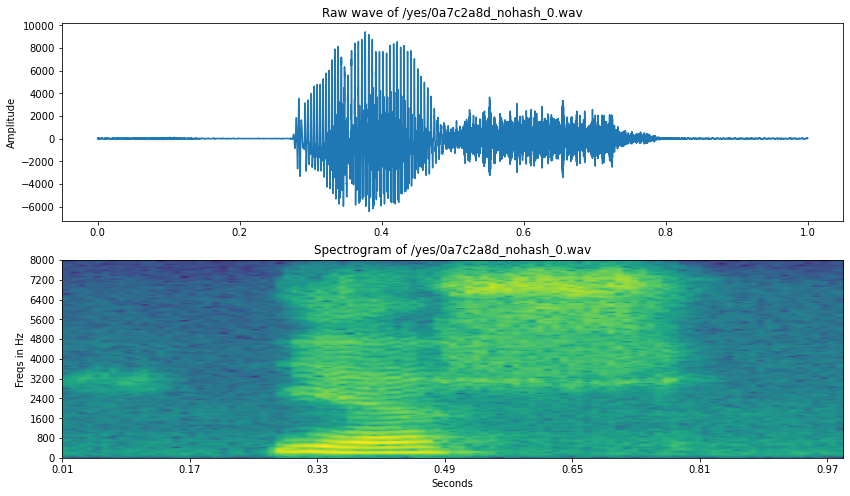

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to noramlize over all the dataset, here's example just for one, which doesn't give good mean and std)

In [6]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = ((spectrogram - mean) / std)

We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, frequency resolution of the ear is 3.6 Hz within the octave of 1000 ~ 2000 Hz. It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

## 1.2 MFCC

/var/folders/ny/473vxrss0zd4s69y33w2wprr0000gn/T/ipykernel_98903/181847273.py:2: FutureWarning:

Pass y=[ 3.9500682e-04  3.7985228e-05 -4.4930135e-04 ...  6.1238185e-04
  8.1404700e-04  6.2680681e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error



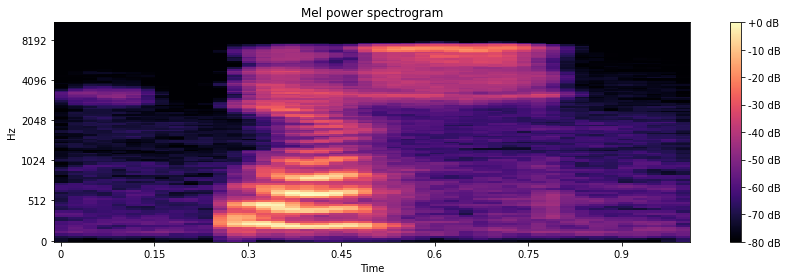

In [7]:
librosa_samples, librosa_sample_rate = librosa.load(str(train_audio_path) + filename)
S = librosa.feature.melspectrogram(librosa_samples, sr=librosa_sample_rate, n_mels=128)

# convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=librosa_sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

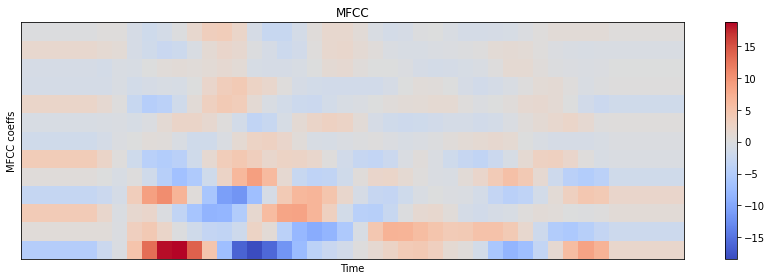

In [8]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.  
  
However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.  
  
It is your decision which to choose.

## 1.3 Spectrogram in 3d

In [9]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
    title = 'Specgtrogram of "yes" in 3d',
    scene = dict(
        yaxis = dict(title='Frequency', range=[freqs.min(), freqs.max()]),
        xaxis = dict(title='Time', range=[times.min(), times.max()]),
        zaxis = dict(title='Log amplitude')
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 1.4 Silence removal

In [10]:
ipd.Audio(samples, rate=sample_rate)

- "Yes"라는 음성이 1초동안 들린다.
  
I consider that some VAD (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent VAD can reduce training size a lot, accelerating training speed significantly. Let's cut a bit of the file from the beginning and from the end. And listen to it again (based on a plot above, we take from 4000 to 13000):

In [12]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

- "Yes"라는 음성이 조금 더 짧은 속도 안에서 재생된다.
  
We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example webrtcvad package to have a good VAD.  
  
Let's plot it again, together with guessed alignment of 'y', 'e', 's' graphems.

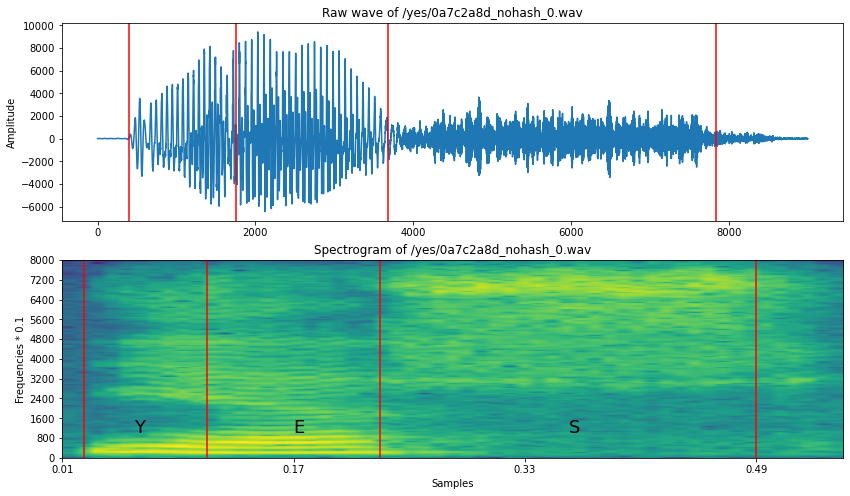

In [13]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5 Resampling - dimensionality reduction

Another way to reduce the dimensionality of our data is to resample recordings.  
  
You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, the most speech related frequencies are presented in smaller band. That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.  
  
Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.  
  
We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.  
  
We'll need to calculate FFT (Fast Fourier Transform). Definition:

In [14]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    vals = 2.0 / N * np.abs(yf[0:N//2]) # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [15]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [16]:
ipd.Audio(samples, rate=sample_rate)

- "Happy" 라는 음성이 1초 동안 들린다.

In [17]:
ipd.Audio(resampled, rate=new_sample_rate)

- "Happy" 라는 음성이 1초 동안 들린다. (samples와 비교했을 때 차이를 인지하지 못할 정도)  
Alomost no difference.

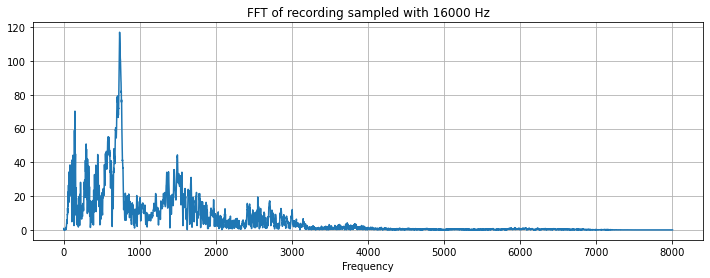

In [18]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

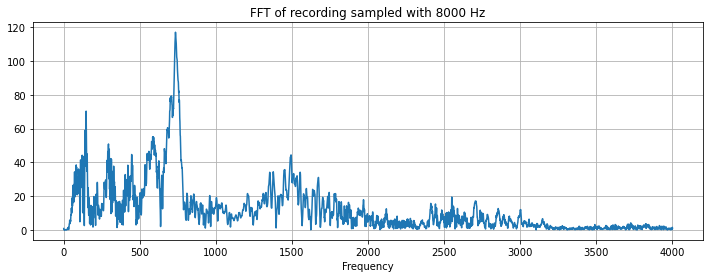

In [19]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice.  
(resampled는 거의 절반 가량으로 시간이 줄었다.)

## 1.6 Features extraction steps

I would propose the feature extraction algorithm like that:  
1. Resampling
2. VAD
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or MFCC, or PLP)
5. Features normalization with mean and std
6. Stacking of a given number of frames to get temporal information

# 2. Dataset investigation

## 2.1 Number of records

In [20]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [21]:
# calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

In [24]:
# plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs, y=number_of_recordings,
    marker=dict(color=number_of_recordings, colorscale='viridis', showscale=True)
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis=dict(title='Words'),
    yaxis=dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

Dataset is balanced except of background_noise, but that's the different thing.

## 2.2 Deeper into recordings

There's a very important fact. Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.  
  
Nevertheliss, **it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets.** Just take a look and listen to this two examples:

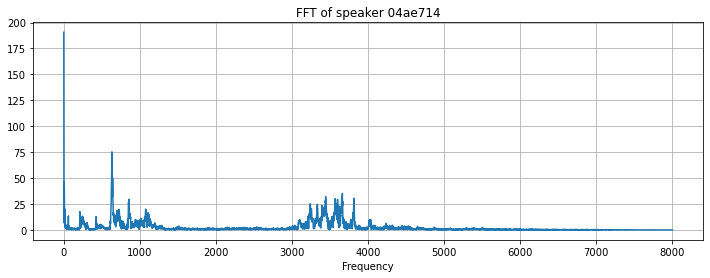

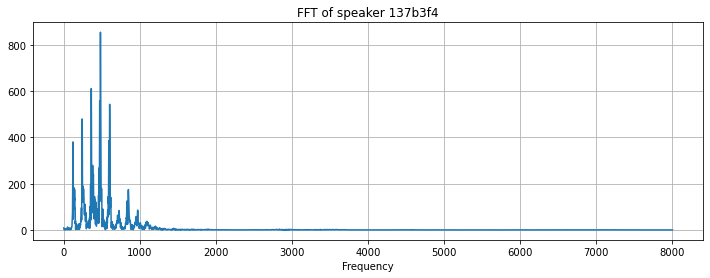

In [25]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

Even better to listen:

In [27]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


- "On"이라는 소리가 작게 들리며, 약간 노이즈도 포함되어 있는 것 같다. (1초)

In [28]:
print('Speaker ' + filename[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 


- "On"이라는 소리가 분명하고 크게 들린다. (1초)  
  
There are also recordings with some weird silence (some compression?):

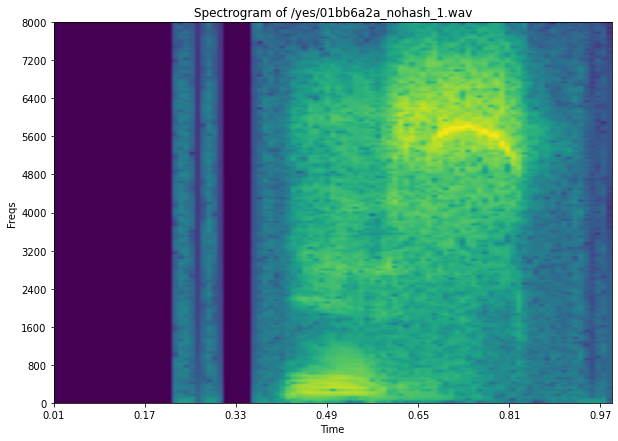

In [29]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

It means, that we have to prevent overfitting to the very specific acoustical environments.

## 2.3 Recordings length

Find if all the files have 1 second duration:

In [30]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1

print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

/var/folders/ny/473vxrss0zd4s69y33w2wprr0000gn/T/ipykernel_98903/4276340876.py:5: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


We can pad them with zeros.

## 2.4 Mean spectrograms and FFT

Let's plot mean FFT for every word.

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


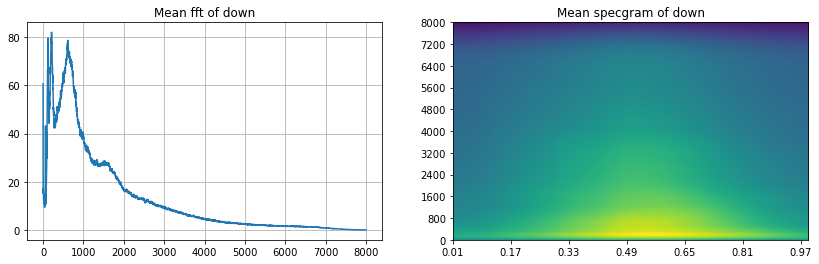

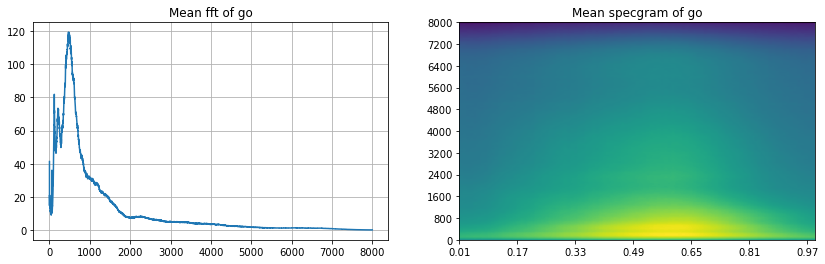

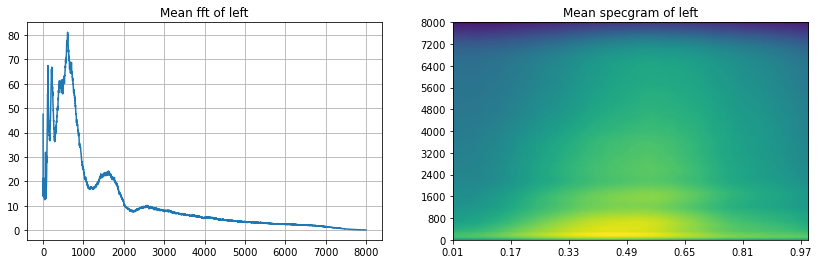

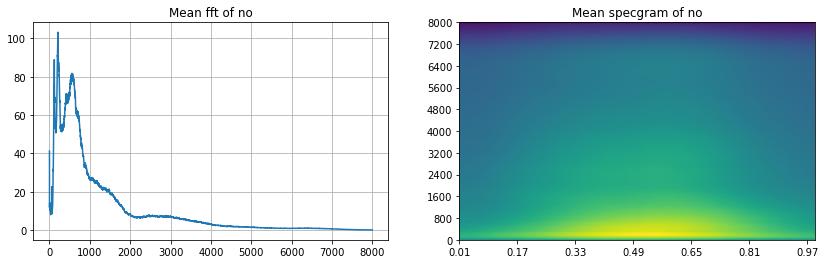

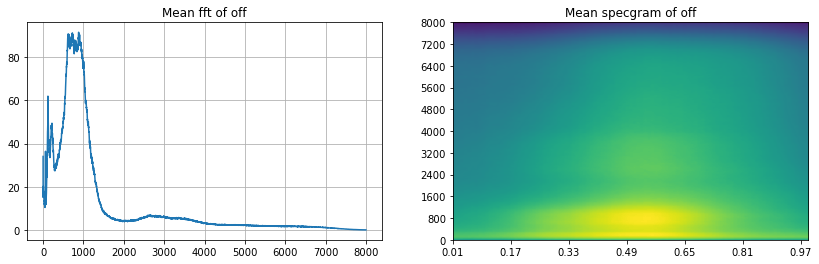

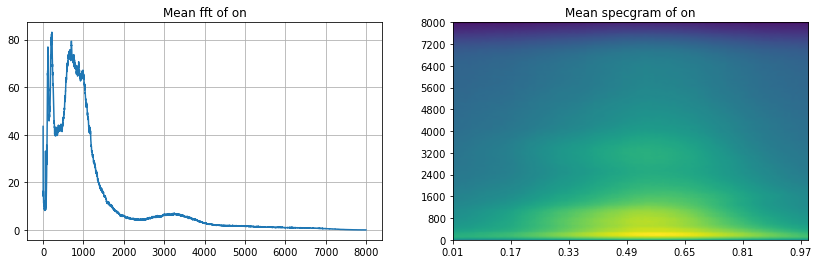

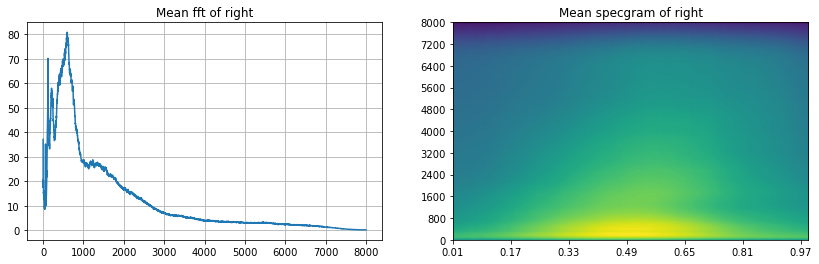

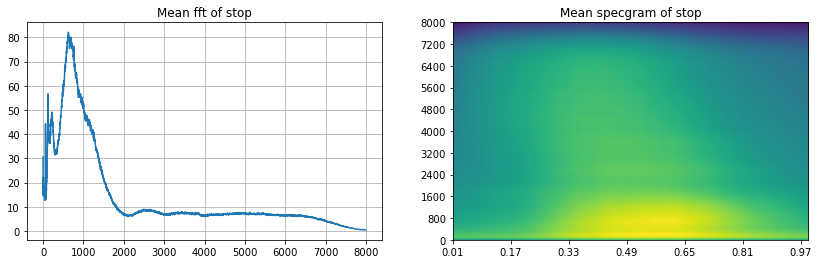

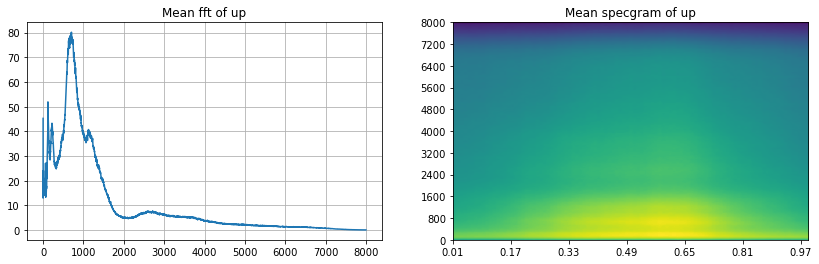

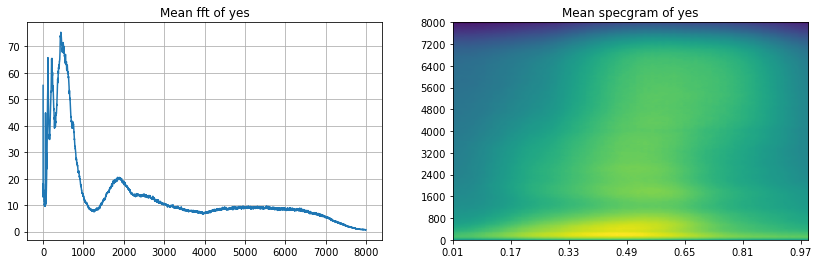

In [31]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()

    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()


## 2.5 Gaussian Mixtures modeling

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like stop and up. But they are still distinguishable when we look at spectrograms. High frequencies are earlier than low at the beginning of stop (probably s).  
  
That's why temporal component is also necessary. There is a Kaldi library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with Hidden Markov Models.  
  
We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use Sikit-learn for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6 Frequency components across the words

In [32]:
def violineplot_frequency(dirs, freq_ind):
    '''plot violineplots for given words (waves in dirs) and frequency freq_ind from all frequencies freqs.'''

    spec_all = []
    ind = 0
    for direct in dirs:
        spec_all.append([])
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1
    
    # different lengths = different num of frames. Make number equal.
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13, 7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

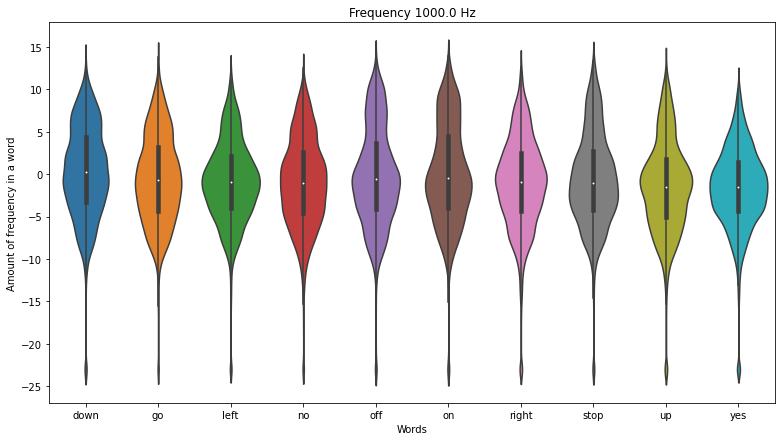

In [33]:
violineplot_frequency(dirs, 20)

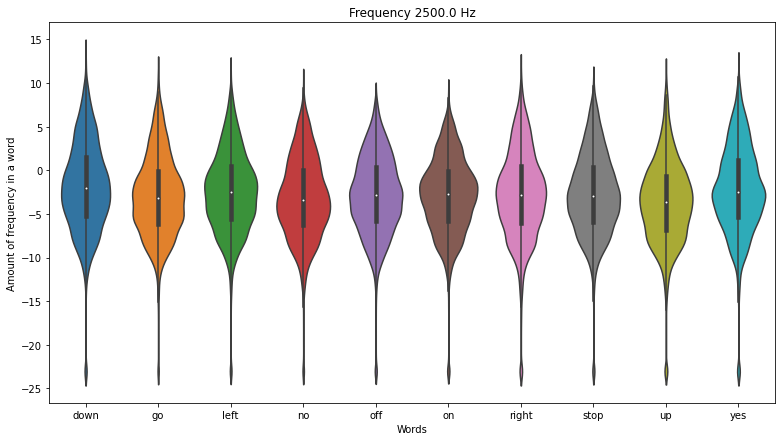

In [34]:
violineplot_frequency(dirs, 50)

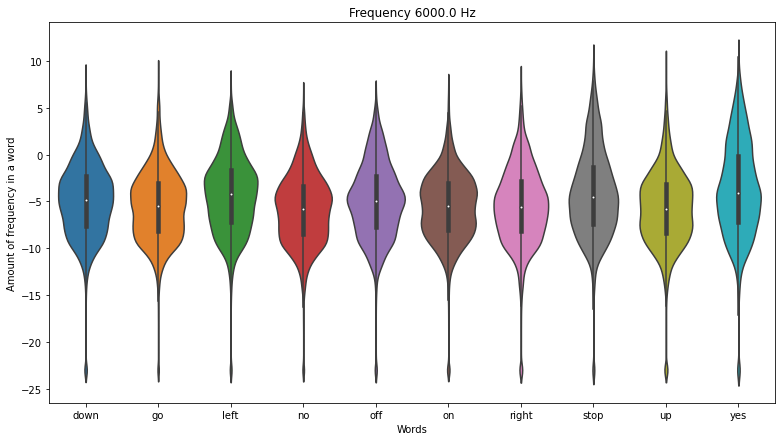

In [35]:
violineplot_frequency(dirs, 120)

## 2.7 Anomaly detection

We should check if there are any recordings that somehow stand out from the rest. We can lower the dimensionality of the dataset and interactively check for any anomaly. We'll use PCA for dimensionality reduction:

In [36]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
            x, val = custom_fft(samples, sample_rate)
            fft_all.append(val)
            names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title='Anomaly detection')
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)

interactive_3d_plot(fft_all, names)

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




Notice that there are yes/e4b02540_nohash_0.wav, go/0487ba9b_nohash_0.wav and more points, that lie far away from the rest. Let's listen to them.  
  
(나의 결과와 다르다. 내 결과는 stop 항목이 눈에 띈다.)

In [38]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


- "Go"라는 음성이 굉장이 노이즈가 껴서 들린다.

In [39]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


- "Yes"라는 음성이 들린다. (s 부분에서 약간 깨지듯이 들리는 것 같기도 하다.)  
  
If you will look for anomalies for individual words, you can find for example this file for seven:

In [40]:
print('Recording seven/b1114e4f_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav'))

Recording seven/b1114e4f_nohash_0.wav


- 아기 목소리로 "Seven" 하는 음성이 1초간 들린다. 굉장이 높고 큰 목소리다.  
  
That's nothing obviously important. Usually you can find some distortions using this method.  
Data seems to contain what is should.